<a href="https://www.kaggle.com/code/nikhil1e9/ps-s3e19-eda-ensemble-postprocessing?scriptVersionId=140401879" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Initial Setup

In [1]:
# importing required libraries
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import holidays 

import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# importing files
filepath = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        filepath.append(os.path.join(dirname, filename))

smooth_train_path, sub_path, train_path, test_path = filepath
train = pd.read_csv(smooth_train_path)
test = pd.read_csv(test_path)
sub = pd.read_csv(sub_path)
print(filepath)

['/kaggle/input/playground-s3e19-covid-data-smoothed/course_sales (1).csv', '/kaggle/input/playground-series-s3e19/sample_submission.csv', '/kaggle/input/playground-series-s3e19/train.csv', '/kaggle/input/playground-series-s3e19/test.csv']


In [3]:
train.head()

,id,date,country,store,product,num_sold
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63.0
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66.0
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9.0
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59.0
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49.0


In [4]:
train.drop('id', axis=1, inplace=True)

## Exploring the data

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136950 entries, 0 to 136949
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   date      136950 non-null  object 
 1   country   136950 non-null  object 
 2   store     136950 non-null  object 
 3   product   136950 non-null  object 
 4   num_sold  136950 non-null  float64
dtypes: float64(1), object(4)
memory usage: 5.2+ MB


In [6]:
# Convert date to datetime format
train['date'] = pd.to_datetime(train['date'])
train.dtypes

date        datetime64[ns]
country             object
store               object
product             object
num_sold           float64
dtype: object

In [7]:
train.duplicated().sum(),\
train.isnull().sum().sum()

(0, 0)

There are no duplicate and null values in the data. No need to worry about data cleaning😄

In [8]:
train.describe(include='all')

,date,country,store,product,num_sold
count,136950,136950,136950,136950,136950.000000
unique,1826,5,3,5,NaN
top,2017-01-01 00:00:00,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,NaN
freq,75,27390,45650,27390,NaN
first,2017-01-01 00:00:00,NaN,NaN,NaN,NaN
last,2021-12-31 00:00:00,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,169.049429
std,NaN,NaN,NaN,NaN,186.399662
min,NaN,NaN,NaN,NaN,2.955517
25%,NaN,NaN,NaN,NaN,47.000000


In [9]:
for col in train.columns:
    if train[col].nunique() > 5:
        print(col+", Unique values:", train[col].nunique())
    else:
        print(col +'\n', train[col].value_counts())
    print()

date, Unique values: 1826

country
 Argentina    27390
Canada       27390
Estonia      27390
Japan        27390
Spain        27390
Name: country, dtype: int64

store
 Kaggle Learn    45650
Kaggle Store    45650
Kagglazon       45650
Name: store, dtype: int64

product
 Using LLMs to Improve Your Coding                 27390
Using LLMs to Train More LLMs                     27390
Using LLMs to Win Friends and Influence People    27390
Using LLMs to Win More Kaggle Competitions        27390
Using LLMs to Write Better                        27390
Name: product, dtype: int64

num_sold, Unique values: 28477



## Visualizing the data

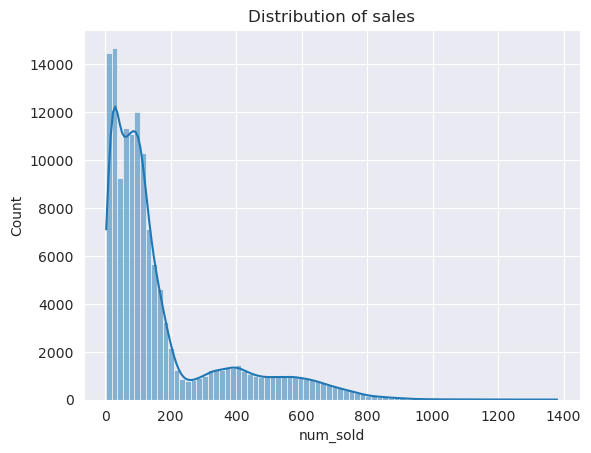

In [10]:
# Distribution of sales
sns.histplot(x='num_sold', data=train, bins=80, kde=True)
plt.title("Distribution of sales")
plt.show()

Looks like a right skewed distribution

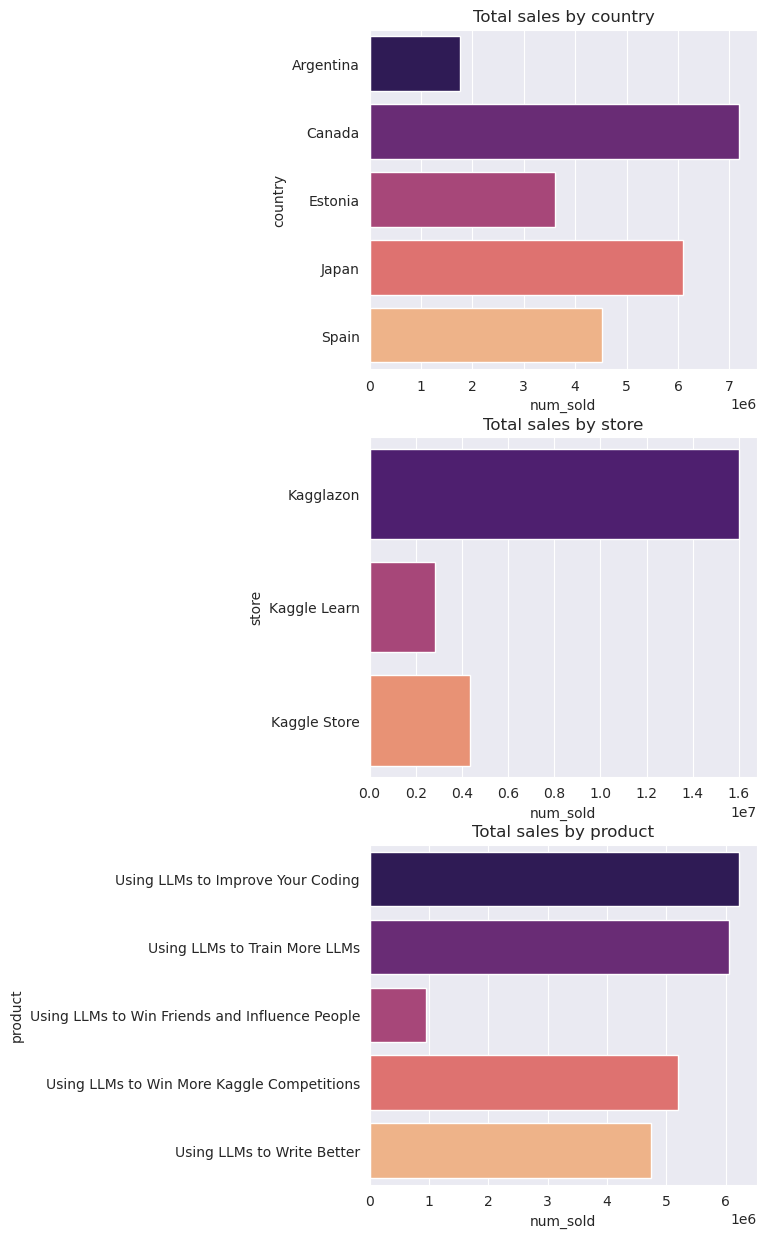

In [11]:
plt.figure(figsize=(5,15))
for i,col in enumerate(['country', 'store', 'product'], start=1):
    ax = plt.subplot(3,1,i)
    df = train.groupby(col)['num_sold'].sum().reset_index()
    sns.barplot(y=col, x='num_sold', data=df, ax=ax, palette='magma')
    plt.title(f"Total sales by {col}")

<Axes: xlabel='country', ylabel='num_sold'>

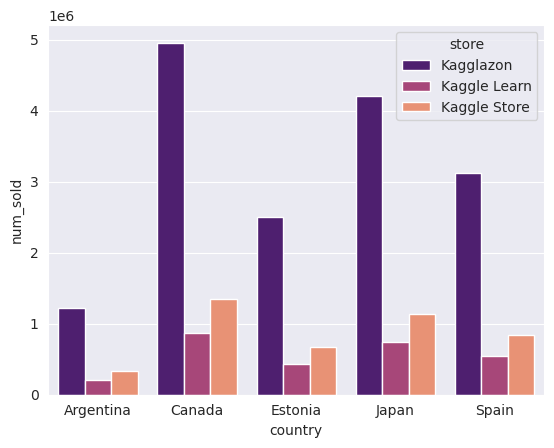

In [12]:
con_store = train.groupby(['country', 'store'])['num_sold'].sum().reset_index()
sns.barplot(x='country', y='num_sold', hue='store', data=con_store, palette='magma')

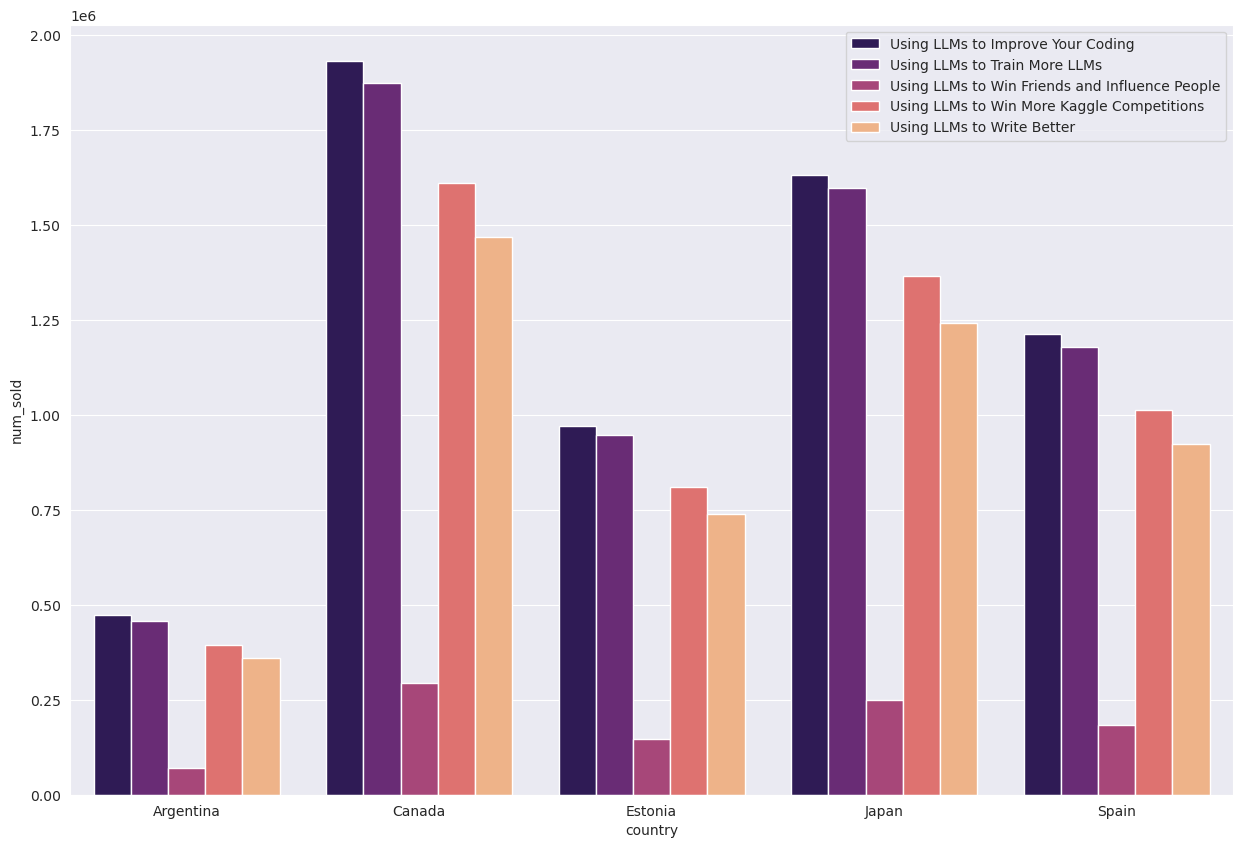

In [13]:
plt.figure(figsize=(15,10))
con_pro = train.groupby(['country', 'product'])['num_sold'].sum().reset_index()
sns.barplot(x='country', y='num_sold', hue='product', data=con_pro, palette='magma')
plt.legend()

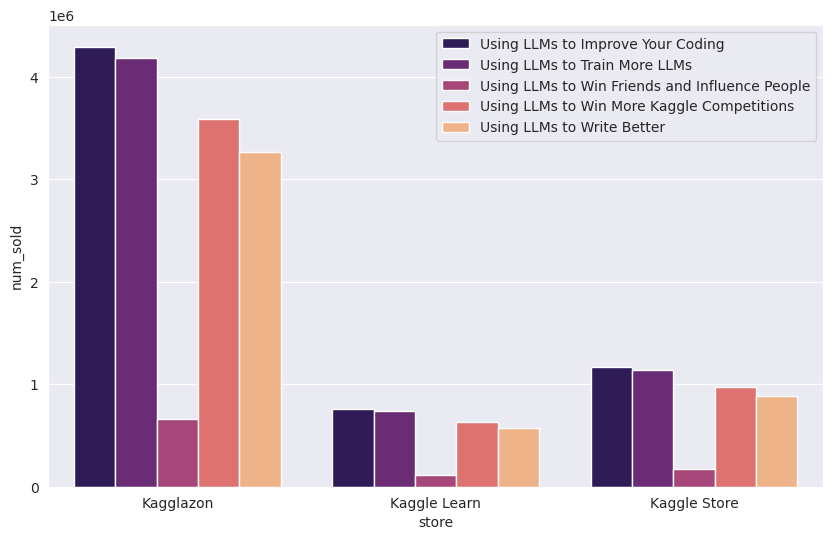

In [14]:
plt.figure(figsize=(10,6))
pro_sto = train.groupby(['store', 'product'])['num_sold'].sum().reset_index()
sns.barplot(x='store', y='num_sold', hue='product', data=pro_sto, palette='magma')
plt.legend()

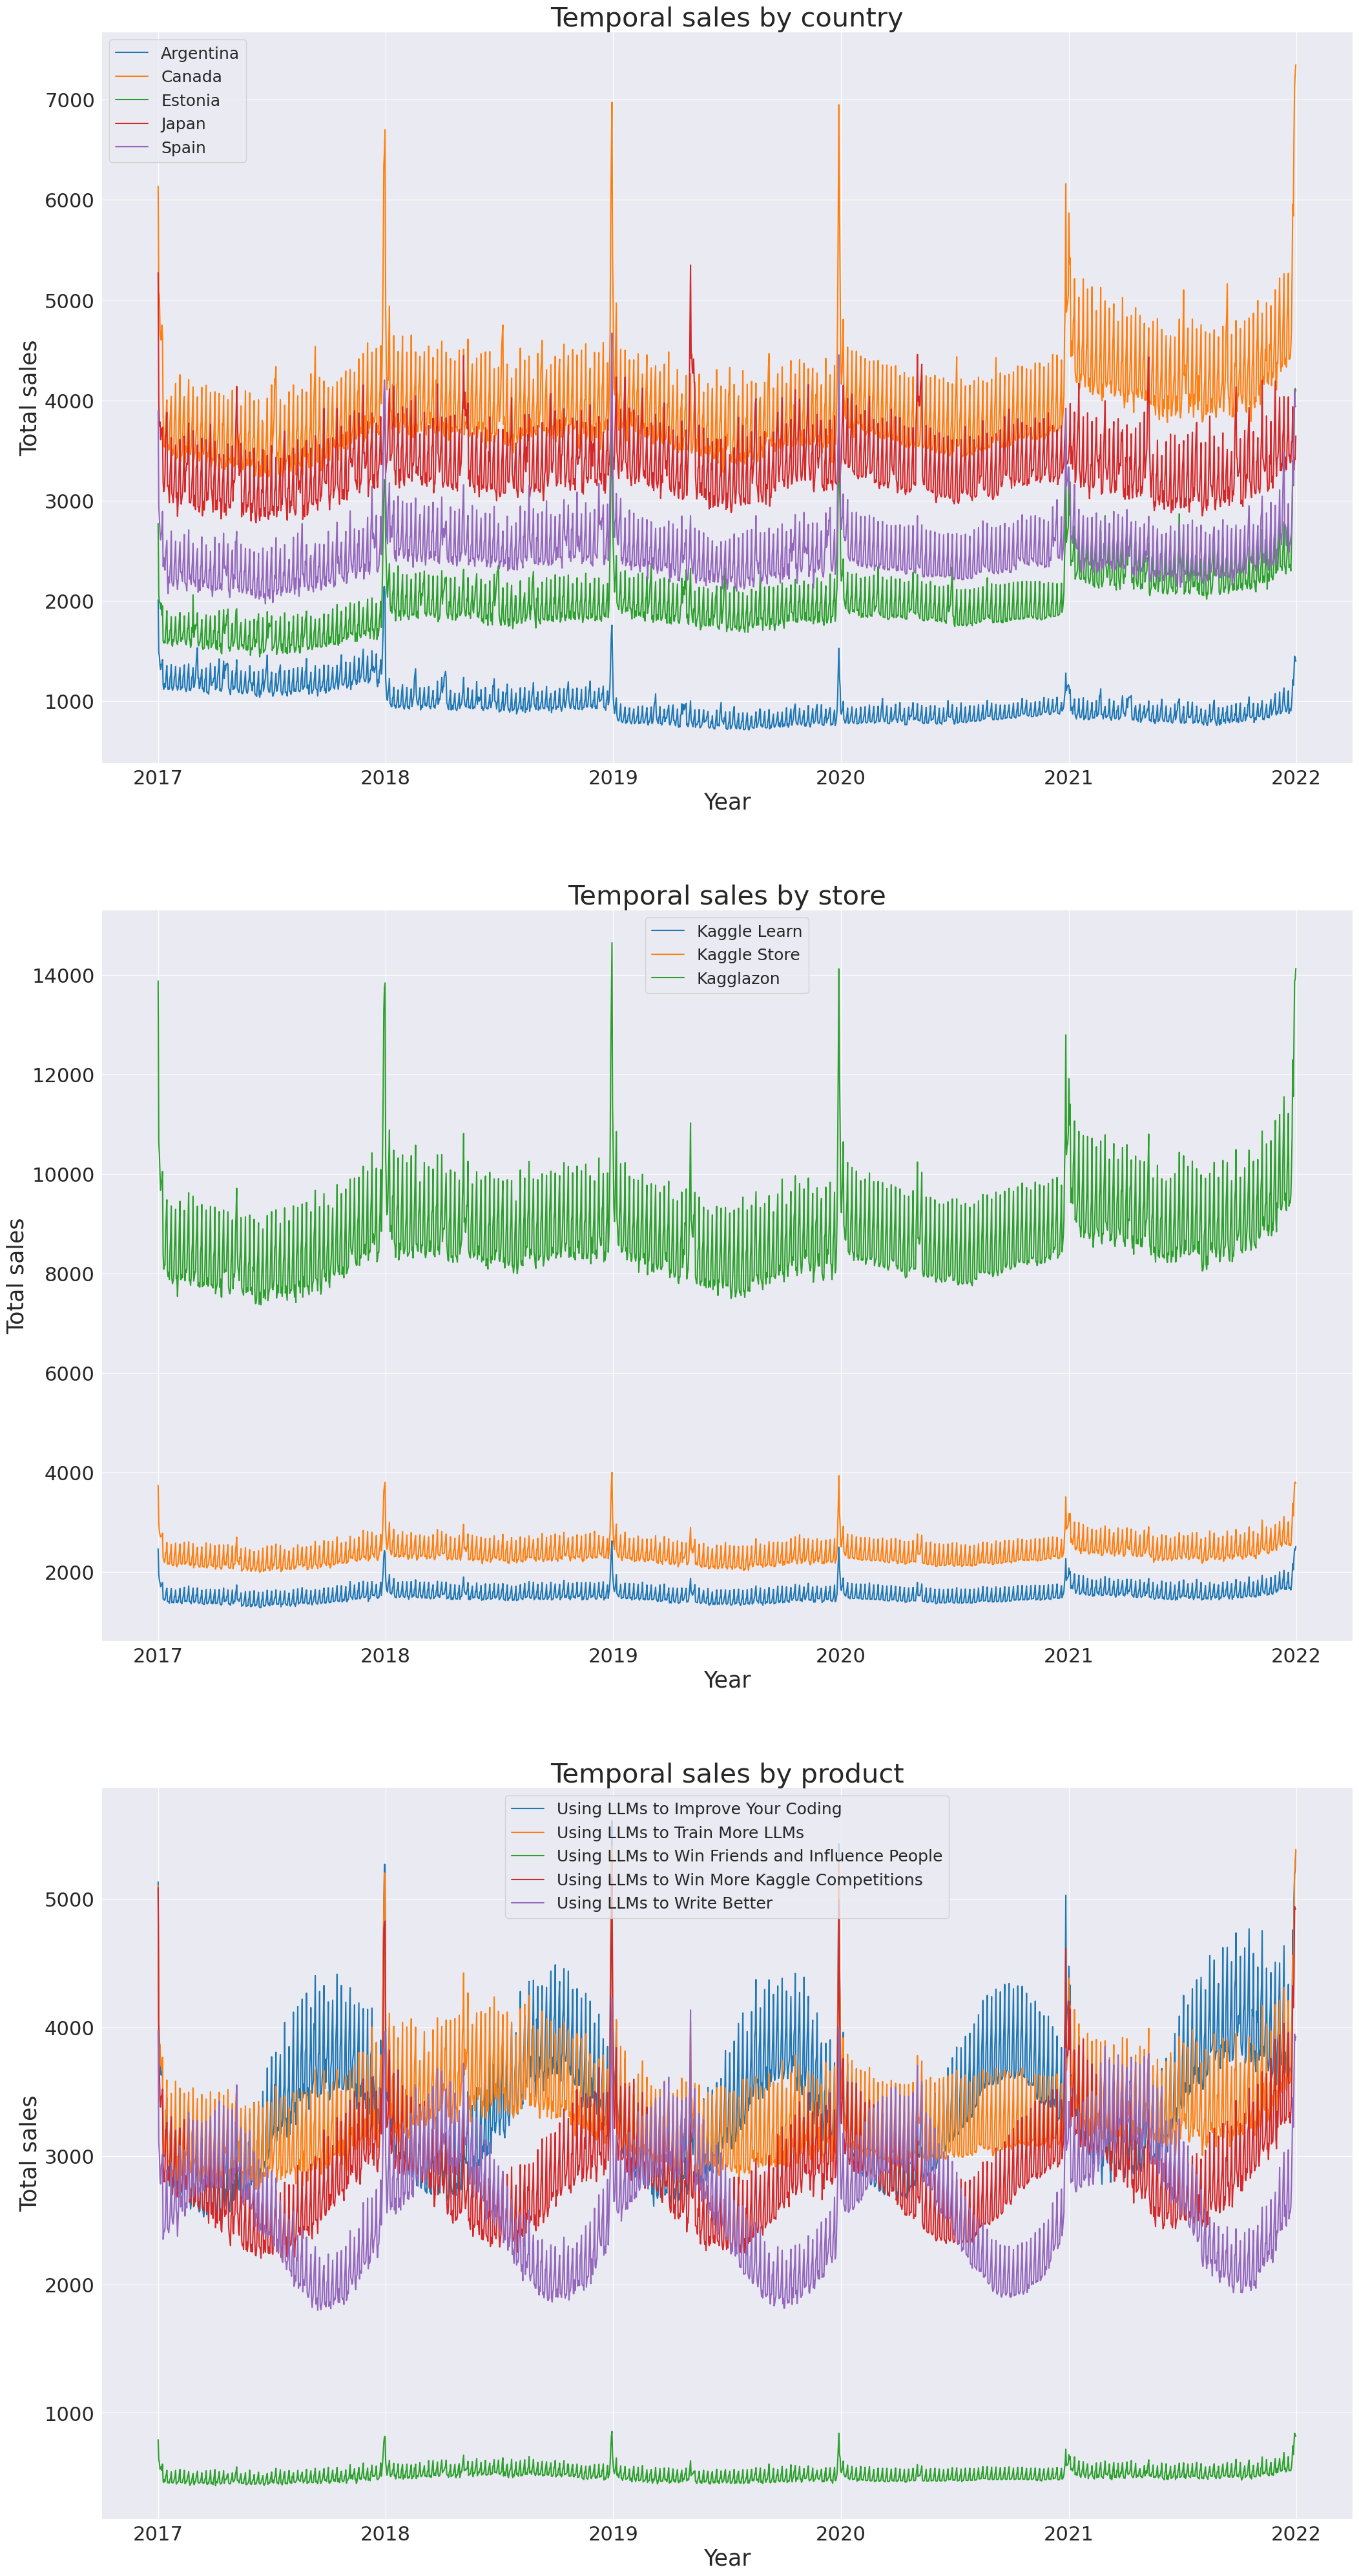

In [15]:
def temp_sales_by_col(col):
    for x in train[col].unique():
        plt.plot(train.groupby([col, 'date'])['num_sold'].sum()[x])
    plt.legend(train[col].unique(), fontsize=18)
    plt.title(f'Temporal sales by {col}', fontsize=30)
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.xlabel('Year', fontsize=25)
    plt.ylabel('Total sales', fontsize=25)
    
fig = plt.figure(figsize=(25,50))

fig.add_subplot(3,1,1)
temp_sales_by_col('country')

fig.add_subplot(3,1,2)
temp_sales_by_col('store')

fig.add_subplot(3,1,3)
temp_sales_by_col('product')

## Feature engineering

In [16]:
train.country.unique()

array(['Argentina', 'Canada', 'Estonia', 'Japan', 'Spain'], dtype=object)

In [17]:
years_list = [2017, 2018, 2019, 2020, 2021, 2022]
# Argentina Holidays 
ARG_hlds = holidays.CountryHoliday('AR', years=years_list)
# Canada Holidays 
CAN_hlds = holidays.CountryHoliday('CA', years=years_list)
# Estonia Holidays 
EST_hlds = holidays.CountryHoliday('EE', years=years_list)
# Japan Holidays 
JPN_hlds = holidays.CountryHoliday('JP', years=years_list)
# Spain Holidays 
ESP_hlds = holidays.CountryHoliday('ES', years=years_list)

In [18]:
def preprocess(df, type='train'):
    if type == 'test':
        df.drop('id', axis=1, inplace=True)
        df['date'] = pd.to_datetime(df['date'])
    
    # Create year, month, day, dayofweek columns
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek

    # Create weekend and Sunday columns
    df['weekend'] = (df['dayofweek'] > 4).astype('int')
    df['sunday'] = (df['dayofweek'] == 6).astype('int')

    # Create Fourier Features to account for seasonality
    df['month_sin'] = np.sin(df['month']*2*np.pi/12)
    df['month_cos'] = np.cos(df['month']*2*np.pi/12)
    df['day_sin'] = np.sin(df['day']*2*np.pi/31)
    df['day_cos'] = np.cos(df['day']*2*np.pi/31)

    # Create holiday columns
    df['ARG_hld'] = df[df['country'] == 'Argentina']['date'].apply(lambda x: x in ARG_hlds)
    df['CAN_hld'] = df[df['country'] == 'Canada']['date'].apply(lambda x: x in CAN_hlds)
    df['EST_hld'] = df[df['country'] == 'Estonia']['date'].apply(lambda x: x in EST_hlds)
    df['JPN_hld'] = df[df['country'] == 'Japan']['date'].apply(lambda x: x in JPN_hlds)
    df['ESP_hld'] = df[df['country'] == 'Spain']['date'].apply(lambda x: x in ESP_hlds)
    df.fillna('', inplace=True)
    df['holiday'] =  df['ARG_hld'].astype('str') + \
                        df['CAN_hld'].astype('str') + \
                        df['EST_hld'].astype('str') + \
                        df['JPN_hld'].astype('str') + \
                        df['ESP_hld'].astype('str')
    df.drop(['ARG_hld', 'CAN_hld', 'EST_hld', 'JPN_hld', 'ESP_hld'], axis=1, inplace=True)
    
    # One hot encoding the categorical features
    df = pd.get_dummies(df, drop_first=True)
    
    return df

In [19]:
# # Create exponential moving avg feature to smoothen the curve
# train['EWMA'] = train['num_sold'].ewm(alpha=0.9).mean()
# fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
# fig.set_figwidth(10)
# fig.set_figheight(5)
# sns.histplot(x='num_sold', data=train, bins=80, kde=True, ax=ax1)
# sns.histplot(x='EWMA', data=train, bins=80, kde=True, ax=ax2)

In [20]:
train_processed = preprocess(train)

# Define features and targets for training
X = train_processed.drop(['date', 'num_sold'], axis=1)
y = train_processed['num_sold']
# X = train_processed.drop(['date', 'num_sold', 'EWMA'], axis=1)
# y = train_processed['EWMA']

In [21]:
X.head()

,year,month,day,dayofweek,weekend,sunday,month_sin,month_cos,day_sin,day_cos,...,country_Estonia,country_Japan,country_Spain,store_Kaggle Learn,store_Kaggle Store,product_Using LLMs to Train More LLMs,product_Using LLMs to Win Friends and Influence People,product_Using LLMs to Win More Kaggle Competitions,product_Using LLMs to Write Better,holiday_True
0,2017,1,1,6,1,1,0.5,0.866025,0.201299,0.97953,...,0,0,0,1,0,0,0,0,0,1
1,2017,1,1,6,1,1,0.5,0.866025,0.201299,0.97953,...,0,0,0,1,0,1,0,0,0,1
2,2017,1,1,6,1,1,0.5,0.866025,0.201299,0.97953,...,0,0,0,1,0,0,1,0,0,1
3,2017,1,1,6,1,1,0.5,0.866025,0.201299,0.97953,...,0,0,0,1,0,0,0,1,0,1
4,2017,1,1,6,1,1,0.5,0.866025,0.201299,0.97953,...,0,0,0,1,0,0,0,0,1,1


## Building models

I will be exploring CatBoost, LightGBM and XGBoost and compare the results.

In [22]:
# Import required modules
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import optuna

SMAPE is the evaluation metric for this challenge. You can learn more about it here https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error

In [23]:
# define evaluation metric
def smape(y_true, y_pred):
    return 1 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)) * 100)
smape_score = make_scorer(smape, greater_is_better=False)

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26)

### Hyperparameter tuning using Optuna

#### CatBoost

In [24]:
def objective_cat(trial):
    """Define the objective function"""
    
    # CatBoost params
    cat_params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 3, 10),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 10),
#         "subsample": trial.suggest_float("subsample", 0.05, 1.0),
#         "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }
    
    cat_scores = []
    # Create a time series split to get train and test sets
    tscv = TimeSeriesSplit(n_splits=3, test_size=len(X)//4)
    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_test, y_test = X.iloc[test_index], y.iloc[test_index]
        
        # Fit the model
        optuna_cat = CatBoostRegressor(**cat_params, silent=True, objective='MAE')
        optuna_cat.fit(X_train, y_train)
    
        # Make predictions
        y_pred_cat = optuna_cat.predict(X_test)
        score = smape(y_test, y_pred_cat)
        cat_scores.append(score)   

    # Evaluate predictions
    return np.mean(cat_scores)

In [25]:
cat_study = optuna.create_study(direction='minimize')
cat_study.optimize(objective_cat, n_trials=10)

[I 2023-08-19 17:44:43,503] A new study created in memory with name: no-name-3ea29953-af12-422f-922f-ed0aa5401ea4
[I 2023-08-19 17:45:06,342] Trial 0 finished with value: 7.445756471775307 and parameters: {'iterations': 556, 'learning_rate': 0.04941402797149911, 'depth': 8, 'l2_leaf_reg': 2}. Best is trial 0 with value: 7.445756471775307.
[I 2023-08-19 17:45:16,633] Trial 1 finished with value: 16.267488402318005 and parameters: {'iterations': 269, 'learning_rate': 0.014780537413123069, 'depth': 7, 'l2_leaf_reg': 2}. Best is trial 0 with value: 7.445756471775307.
[I 2023-08-19 17:45:23,215] Trial 2 finished with value: 23.15760378941455 and parameters: {'iterations': 216, 'learning_rate': 0.02308385477115345, 'depth': 4, 'l2_leaf_reg': 10}. Best is trial 0 with value: 7.445756471775307.
[I 2023-08-19 17:45:30,812] Trial 3 finished with value: 24.24562131593284 and parameters: {'iterations': 272, 'learning_rate': 0.06113271820306652, 'depth': 3, 'l2_leaf_reg': 7}. Best is trial 0 with v

In [26]:
# Choose the best set of hyperparams
def results_optuna(study):
    print('Number of finished trials:', len(study.trials))
    trial = study.best_trial
    print('Best trial value:', trial.value)
    print('Best Params:', study.best_params)
    return study.best_params

In [27]:
best_params_cat = results_optuna(cat_study)

Number of finished trials: 10
Best trial value: 7.445756471775307
Best Params: {'iterations': 556, 'learning_rate': 0.04941402797149911, 'depth': 8, 'l2_leaf_reg': 2}


#### XGBoost

In [28]:
def objective_xgb(trial):
    """Define the objective function"""
    
    # XGBoost params
    xgb_params = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
#         'max_delta_step': trial.suggest_float('max_delta_step', 1, 10),
#         'subsample': trial.suggest_float('subsample', 0.01, 1.0, log=True),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0, log=True),
#         'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
#         'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'eval_metric': 'mae'
    }

    xgb_scores = []
    tscv = TimeSeriesSplit(n_splits=3, test_size=len(X)//4)
    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_test, y_test = X.iloc[test_index], y.iloc[test_index]
        
        # Fit the model
        optuna_xgb = XGBRegressor(**xgb_params)
        optuna_xgb.fit(X_train, y_train)
        
        # Make predictions
        y_pred_xgb = optuna_xgb.predict(X_test)
        score = smape(y_test, y_pred_xgb)
        xgb_scores.append(score)
        
    # Evaluate predictions
    return np.mean(xgb_scores)

In [29]:
xgb_study = optuna.create_study(direction='minimize')
xgb_study.optimize(objective_xgb, n_trials=10)

[I 2023-08-19 17:47:23,453] A new study created in memory with name: no-name-bfb3dbda-3c05-4628-9707-1d3837333a62
[I 2023-08-19 17:47:42,853] Trial 0 finished with value: 19.98215752939316 and parameters: {'max_depth': 6, 'learning_rate': 0.01652430076799003, 'n_estimators': 157, 'min_child_weight': 5}. Best is trial 0 with value: 19.98215752939316.
[I 2023-08-19 17:47:58,944] Trial 1 finished with value: 13.544569630783556 and parameters: {'max_depth': 6, 'learning_rate': 0.03695267457525747, 'n_estimators': 119, 'min_child_weight': 5}. Best is trial 1 with value: 13.544569630783556.
[I 2023-08-19 17:48:03,245] Trial 2 finished with value: 65.27463612497243 and parameters: {'max_depth': 1, 'learning_rate': 0.01379591827386381, 'n_estimators': 159, 'min_child_weight': 10}. Best is trial 1 with value: 13.544569630783556.
[I 2023-08-19 17:48:15,679] Trial 3 finished with value: 8.649065131368545 and parameters: {'max_depth': 8, 'learning_rate': 0.0571360120357106, 'n_estimators': 69, 'mi

In [30]:
best_params_xgb = results_optuna(xgb_study)

Number of finished trials: 10
Best trial value: 8.649065131368545
Best Params: {'max_depth': 8, 'learning_rate': 0.0571360120357106, 'n_estimators': 69, 'min_child_weight': 6}


#### LightGBM

In [31]:
def objective_lgbm(trial):
    """Define the objective function"""
    
    # LightGBM params
    lgbm_params = {
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 10, 300),
            'num_leaves': trial.suggest_int('num_leaves', 10, 200),
            'min_child_samples': trial.suggest_int('min_child_samples', 20, 200)
#             'subsample': trial.suggest_float('subsample', 0.01, 1.0, log=True),
#             'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0, log=True),
#             'metric': ['l1', 'l2'],
#             'boosting_type': 'gbdt',
            # 'device': 'gpu'
    }
    
    lgbm_scores = []
    tscv = TimeSeriesSplit(n_splits=3, test_size=len(X)//4)
    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_test, y_test = X.iloc[test_index], y.iloc[test_index]

        # Fit the model
        optuna_lgbm = LGBMRegressor(**lgbm_params, objective='mae')
        optuna_lgbm.fit(X_train, y_train)

        # Make predictions
        y_pred_lgbm = optuna_lgbm.predict(X_test)
        score = smape(y_test, y_pred_lgbm)
        lgbm_scores.append(score)

    # Evaluate predictions
    return np.mean(lgbm_scores)

In [32]:
lgbm_study = optuna.create_study(direction='minimize')
lgbm_study.optimize(objective_lgbm, n_trials=10)

[I 2023-08-19 17:49:32,065] A new study created in memory with name: no-name-5d3bf9ab-de2f-4d79-a74a-98475b9dbcfd
[I 2023-08-19 17:49:40,452] Trial 0 finished with value: 20.885225085664022 and parameters: {'learning_rate': 0.03974961755872017, 'n_estimators': 50, 'num_leaves': 163, 'min_child_samples': 165}. Best is trial 0 with value: 20.885225085664022.
[I 2023-08-19 17:49:50,444] Trial 1 finished with value: 15.092339877229909 and parameters: {'learning_rate': 0.03498005672940203, 'n_estimators': 78, 'num_leaves': 124, 'min_child_samples': 55}. Best is trial 1 with value: 15.092339877229909.
[I 2023-08-19 17:50:25,052] Trial 2 finished with value: 7.2922498731775605 and parameters: {'learning_rate': 0.07443883396830468, 'n_estimators': 247, 'num_leaves': 149, 'min_child_samples': 96}. Best is trial 2 with value: 7.2922498731775605.
[I 2023-08-19 17:50:27,225] Trial 3 finished with value: 41.81694436351922 and parameters: {'learning_rate': 0.021987668301731836, 'n_estimators': 38, '

In [33]:
best_params_lgbm = results_optuna(lgbm_study)

Number of finished trials: 10
Best trial value: 7.2922498731775605
Best Params: {'learning_rate': 0.07443883396830468, 'n_estimators': 247, 'num_leaves': 149, 'min_child_samples': 96}


## Predictions on validation set (Model Ensemble)

I will use the model ensemble for testing the models predictions on the validation set. To create the ensemble I will use weighted mean scores of all 3 models. Weight in this case will be the inverse of the smape score.

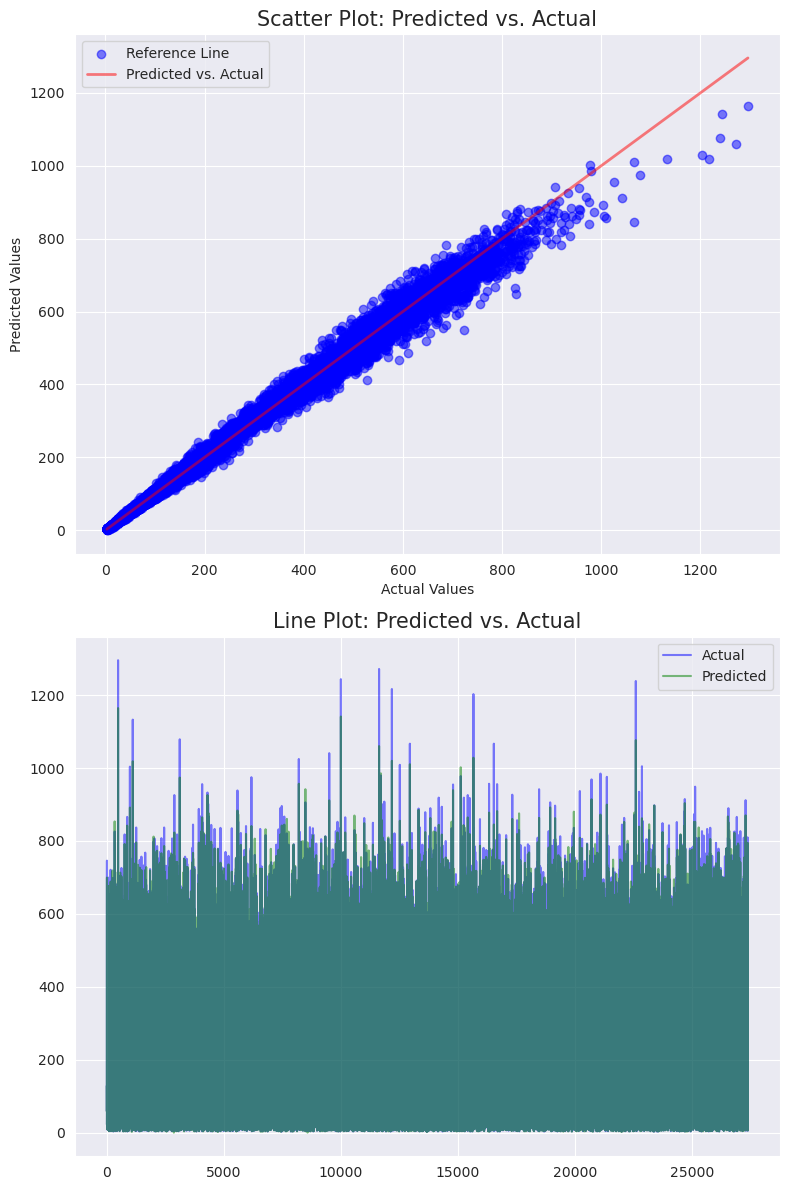

Test set SMAPE:  4.702862231450213


In [34]:
# Train model with best parameters
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26)
model_lgbm = LGBMRegressor(**best_params_lgbm)
model_xgb = XGBRegressor(**best_params_xgb)
model_cat = CatBoostRegressor(**best_params_cat, silent=True)

model_lgbm.fit(X_train, y_train.values.ravel())
model_xgb.fit(X_train, y_train.values.ravel())
model_cat.fit(X_train, y_train.values.ravel())

# Make predictions
predictions_lgbm = model_lgbm.predict(X_test)
predictions_xgb = model_xgb.predict(X_test)
predictions_cat = model_cat.predict(X_test)

# Calculate smape values
smape_lgbm = smape(y_test.values.ravel(), predictions_lgbm)
smape_xgb = smape(y_test.values.ravel(), predictions_xgb)
smape_cat = smape(y_test.values.ravel(), predictions_cat)

# Weighted predictions
# w1*p1+w2*p2+w3*p3 / w1+w2+w3 where (w = 1/smape)
weighted_sum = (1/smape_lgbm) * predictions_lgbm + (1/smape_xgb) * predictions_xgb + (1/smape_cat) * predictions_cat
sum_weights = (1/smape_lgbm) + (1/smape_xgb) + (1/smape_cat)
weighted_preds = weighted_sum / sum_weights

# Create subplots 
fig, axes = plt.subplots(2, 1, figsize=(8, 12))

# Scatter plot of actual values vs predicted values
axes[0].scatter(y_test, weighted_preds, color='blue', alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', alpha=0.5, linewidth=2)
axes[0].set_xlabel('Actual Values')
axes[0].set_ylabel('Predicted Values')
axes[0].set_title('Scatter Plot: Predicted vs. Actual', fontsize=15)
axes[0].legend(['Reference Line', 'Predicted vs. Actual'], fontsize=10)

# Line plot of actual values and predicted values
axes[1].plot(y_test.values.ravel(), color='blue', alpha=0.5, label='Actual')
axes[1].plot(weighted_preds, color='green', alpha=0.5, label='Predicted')
axes[1].set_title('Line Plot: Predicted vs. Actual', fontsize=15)
axes[1].legend(fontsize=10)

plt.tight_layout()
plt.show()

# Test set SMAPE
print("Test set SMAPE: ", smape(y_test.values.ravel(), weighted_preds))

The validation set predicitons are very good but the model will not produce such good results for the final test set. The key is to post process the test predictions to get a better score. I will be showing that in the next section.

## Final Predictions

In [35]:
# Processing the test data
test = pd.read_csv(test_path)
test_df = preprocess(test, type='test')
test_df.drop('date', axis=1, inplace=True)
test_df.head()

,year,month,day,dayofweek,weekend,sunday,month_sin,month_cos,day_sin,day_cos,...,country_Estonia,country_Japan,country_Spain,store_Kaggle Learn,store_Kaggle Store,product_Using LLMs to Train More LLMs,product_Using LLMs to Win Friends and Influence People,product_Using LLMs to Win More Kaggle Competitions,product_Using LLMs to Write Better,holiday_True
0,2022,1,1,5,1,0,0.5,0.866025,0.201299,0.97953,...,0,0,0,1,0,0,0,0,0,1
1,2022,1,1,5,1,0,0.5,0.866025,0.201299,0.97953,...,0,0,0,1,0,1,0,0,0,1
2,2022,1,1,5,1,0,0.5,0.866025,0.201299,0.97953,...,0,0,0,1,0,0,1,0,0,1
3,2022,1,1,5,1,0,0.5,0.866025,0.201299,0.97953,...,0,0,0,1,0,0,0,1,0,1
4,2022,1,1,5,1,0,0.5,0.866025,0.201299,0.97953,...,0,0,0,1,0,0,0,0,1,1


In [36]:
# Make predictions on the final test set using weighted avg of models
best_model_cat = CatBoostRegressor(**best_params_cat, silent=True)
best_model_xgb = XGBRegressor(**best_params_xgb)
best_model_lgbm = LGBMRegressor(**best_params_lgbm)

best_model_cat.fit(X, y)
best_model_xgb.fit(X, y)
best_model_lgbm.fit(X, y)

y_cat = best_model_cat.predict(test_df)
y_xgb = best_model_xgb.predict(test_df)
y_lgbm = best_model_lgbm.predict(test_df)

# weights = [1/smape_lgbm, 1/smape_xgb, 1/smape_cat]
# weighted_sum = weights[0] * y_lgbm + weights[1] * y_xgb + weights[2] * y_cat

# y_sub_weighted = weighted_sum / sum(weights)
y_sub = (y_cat + y_xgb + y_lgbm) / 3

Both weighted and simple averages are doing similar so pick any of the two or try both

## Post processing

This would be the most crucial step for making better predictions
In this step we would be accounting for the differences in distribution of sales across countries. This is done by multiplying each country's predictions by a certain factor to make avg distribution of sales the same across all countries

In [37]:
temp_df = test.copy()
temp_df['num_sold'] = y_sub
# temp_df['num_sold'] = y_sub_weighted
temp_df.head()

,date,country,store,product,year,month,day,dayofweek,weekend,sunday,month_sin,month_cos,day_sin,day_cos,holiday,num_sold
0,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,2022,1,1,5,1,0,0.5,0.866025,0.201299,0.97953,True,43.262618
1,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,2022,1,1,5,1,0,0.5,0.866025,0.201299,0.97953,True,41.510427
2,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,2022,1,1,5,1,0,0.5,0.866025,0.201299,0.97953,True,4.010012
3,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,2022,1,1,5,1,0,0.5,0.866025,0.201299,0.97953,True,40.044622
4,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,2022,1,1,5,1,0,0.5,0.866025,0.201299,0.97953,True,28.684945


In [38]:
# Postprocess predictions to have equal mean distribution across each country
country_mean = temp_df.groupby('country')[['num_sold']].mean()
country_mean_sum = country_mean.sum()
mean_country_df = 1 / ((country_mean / country_mean_sum) / 0.31)
mean_country_df

,num_sold
country,
Argentina,4.549298
Canada,0.956184
Estonia,1.807824
Japan,1.244846
Spain,1.656437


In [39]:
for i, x in temp_df.iterrows():
    y_sub[i] = (mean_country_df.loc[x['country']] * x['num_sold'])['num_sold']
y_sub

array([ 196.81454838,  188.84330594,   18.24273863, ...,  193.09034156,
       1035.17214999,  857.38917878])

In [40]:
# for i, x in temp_df.iterrows():
#     y_sub_weighted[i] = (mean_country_df.loc[x['country']] * x['num_sold'])['num_sold']
# y_sub_weighted

Converting float values to int in the final predictions will help lower the score.

In [41]:
# Final predictions 
sub['num_sold'] = np.round(y_sub, 0)